# mapping-challenge-mask_rcnn-prediction-submission
![CrowdAI-Logo](https://github.com/crowdAI/crowdai/raw/master/app/assets/images/misc/crowdai-logo-smile.svg?sanitize=true)

This notebook contains the code for making predictions from the model trained in [Training.ipynb](Training.ipynb) (or by using the [released pretrained model](https://www.crowdai.org/challenges/mapping-challenge/dataset_files)) for the [crowdAI Mapping Challenge](https://www.crowdai.org/challenges/mapping-challenge).

This code is adapted from the [Mask RCNN]() tensorflow implementation available here : [https://github.com/matterport/Mask_RCNN](https://github.com/matterport/Mask_RCNN).

First we begin by importing all the necessary dependencies : 

In [1]:
import os
import sys
import time
import numpy as np
import skimage.io

# Download and install the Python COCO tools from https://github.com/waleedka/coco
# That's a fork from the original https://github.com/pdollar/coco with a bug
# fix for Python 3.
# I submitted a pull request https://github.com/cocodataset/cocoapi/pull/50
# If the PR is merged then use the original repo.
# Note: Edit PythonAPI/Makefile and replace "python" with "python3".
#  
# A quick one liner to install the library 
# !pip install git+https://github.com/waleedka/coco.git#subdirectory=PythonAPI

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import coco #a slightly modified version

from mrcnn.evaluate import build_coco_results, evaluate_coco
from mrcnn.dataset import MappingChallengeDataset
from mrcnn import visualize


import zipfile
import urllib.request
import shutil
import glob
import tqdm
import random

c:\Users\pr3b\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\pr3b\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\pr3b\AppData\Local\Programs\Python\Python36\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\pr3b\AppData\

## Dataset location 
Now we expect that you have downloaded all the files in the datasets section and untar-ed them to have the following structure :
```
├── data
|   ├── pretrained_weights.h5 (already included in this repository)
│   ├── test
│   │   └── images/
│   │   └── annotation.json
│   ├── train
│   │   └── images/
│   │   └── annotation.json
│   └── val
│       └── images/
│       └── annotation.json
```

In [2]:
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils


PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"data/" "pretrained_weights.h5")
# PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"data/\" \"pretrained_weights.h5\"),
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "data", "test", "images")

# Instantitate Inference Config

In [3]:
class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 5
    NUM_CLASSES = 1 + 1  # 1 Background + 1 Building
    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320
    NAME = "crowdai-mapping-challenge"
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     5
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 5
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           crowdai-mapping-challenge
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENC

# Instantiate Model

In [4]:
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model_path = PRETRAINED_MODEL_PATH

# or if you want to use the latest trained model, you can use : 
# model_path = model.find_last()[1]

model.load_weights(model_path, by_name=True)


# Run Prediction on a single Image (and visualize results)

In [5]:
class_names = ['BG', 'building'] # In our case, we have 1 class for the background, and 1 class for building

Processing 5 images
image                    shape: (300, 300, 3)         min:   12.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:   12.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:   12.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:   12.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (5, 320, 320, 3)      min: -105.70000  max:  151.10000  float64
image_metas              shape: (5, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (5, 25575, 4)         min:   -1.13492  max:    1.93429  float32


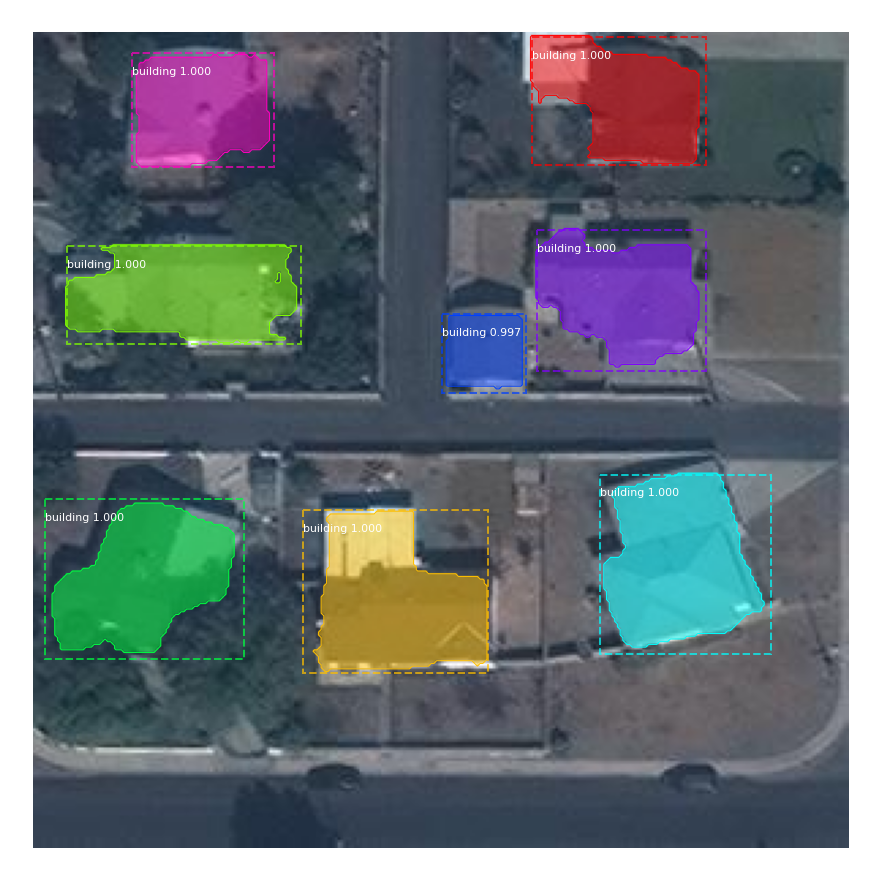

In [6]:
file_names = next(os.walk(IMAGE_DIR))[2]

# file_names = os.listdir(IMAGE_DIR)
# file_names = os.path.abspath(IMAGE_DIR)
random_image = skimage.io.imread(os.path.join(IMAGE_DIR, "000000000005.jpg"))

predictions = model.detect([random_image]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size

p = predictions[0]
visualize.display_instances(random_image, p['rois'], p['masks'], p['class_ids'], 
                            class_names, p['scores'])

In [7]:
import cv2
import os

file_names = next(os.walk(IMAGE_DIR))[2]

# Load the image
image = cv2.imread(os.path.join(IMAGE_DIR, "000000000005.jpg"))

# Detect objects in the image
predictions = model.detect([image]*config.BATCH_SIZE, verbose=1)
p = predictions[0]

# Get the class IDs of the detected objects
class_ids = p['class_ids']

# Get the indices of the detected buildings
building_indices = [i for i, class_id in enumerate(class_ids) if class_id == class_names.index("building")]

# Draw bounding box and mask overlay on original image
for i in building_indices:
    # Get the bounding box coordinates of the building
    y1, x1, y2, x2 = p['rois'][i]

    # Draw the bounding box on the image
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Get the mask for the building
    mask = p['masks'][:,:,i]

    # Draw the mask overlay on the image
    mask_overlay = (0.3 * image + 0.7 * (mask[..., None] > 0) * [255, 255, 255]).astype('uint8')
    mask_overlay[mask == 0] = [0, 0, 0]  # Set the unmasked part to black
    image = cv2.addWeighted(image, 0.5, mask_overlay, 0.5, 0)

    # Crop the building from the image
    building = image[y1:y2, x1:x2]

    # Save the building as a separate file
    cv2.imwrite(f"building-5-{i}.jpg", building)


Processing 5 images
image                    shape: (300, 300, 3)         min:   12.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:   12.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:   12.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:   12.00000  max:  255.00000  uint8
image                    shape: (300, 300, 3)         min:   12.00000  max:  255.00000  uint8
molded_images            shape: (5, 320, 320, 3)      min:  -85.90000  max:  149.10000  float64
image_metas              shape: (5, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (5, 25575, 4)         min:   -1.13492  max:    1.93429  float32


In [8]:
import cv2

# Load the image in grayscale mode
image = cv2.imread("building5.jpg", cv2.IMREAD_GRAYSCALE)

# Apply bitwise thresholding to convert the image to black and white
_, bw_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Save the black and white image
cv2.imwrite("building5-bw.jpg", bw_image)

[[164   3 229  78]
 [ 66 154 133 245]
 [159 207 230 274]
 [ 76  18 116 100]
 [172  97 235 171]
 [  0 179  49 262]
 [  4  33  48  88]]


In [1]:
print(p['rois'])

NameError: name 'p' is not defined

In [6]:
#Area calculation

import cv2
import numpy as np

# Load the image in grayscale mode
image = cv2.imread("rooftop_mask_example.jpg", cv2.IMREAD_GRAYSCALE)

# Apply bitwise thresholding to convert the image to black and white
_, bw_image = cv2.threshold(image, 100, 255, cv2.THRESH_BINARY)

n_black_pix = np.sum(bw_image == 0)
n_white_pix = np.sum(bw_image == 255)
print('Number of black pixels:', n_black_pix)
print('Number of white pixels:', n_white_pix)

print('Rooftop area:', n_white_pix)
print('Rooftop percentage:', n_white_pix/(n_black_pix+n_white_pix))



Number of black pixels: 1759
Number of white pixels: 2998
Rooftop area: 2998
Rooftop percentage: 0.6302291360100903


True